# Inspect Rich Documents with Gemini Multimodality and Multimodal RAG Challenge Lab

## Getting Started

### Install Vertex AI SDK for Python and other dependencies

In [1]:
# Install required python packages and other dependencies
!pip3 install --upgrade --user google-cloud-aiplatform

!pip3 install --upgrade --user google-cloud-aiplatform pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 34.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 49.9 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart current runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# restart the kernet after libraries are loaded
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information and initialize Vertex AI
Initialize the Vertex AI SDK for Python for your project:

In [1]:
import sys

# Define project information
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

Your project ID is: qwiklabs-gcp-01-e0030708cabb


In [2]:
# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

2024-03-12 18:26:23.625255: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 18:26:23.692474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 18:26:23.692541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 18:26:23.694741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 18:26:23.710763: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 18:26:23.712867: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Task 1. Use the Gemini Pro Vision model

Gemini 1.0 Pro Vision (`gemini-1.0-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.

### Import libraries

In [3]:
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

### Load Gemini 1.0 Pro Vision model

In [4]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Define helper functions

In [6]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

### Complete the missing parts

For this task, complete the missing parts of each cell to progress to the next section. These will be denoted with INSERT and an instruction to complete.

**Note:** You can skip any notebook cells that are noted Colab only. **

#### Task 1.1. Image Understanding across multiple images

-------Prompt--------
Instructions: Consider the following image that contains text:


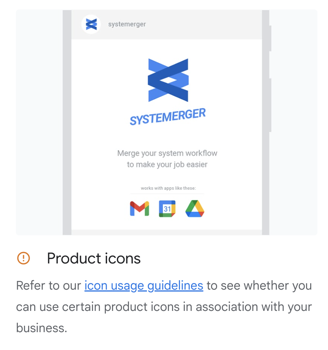

What is the title of this image


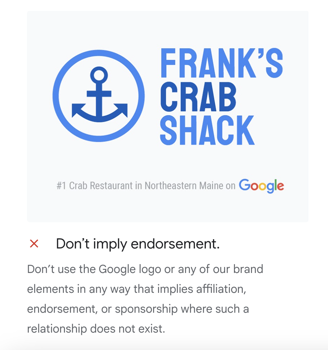


Answer the question through these steps:
Step 1: Identify the title of each image by using the filename of each image.
Step 2: Describe the image.
Step 3: For each image, describe the actions that a user is expected to take.
Step 4: Extract the text from each image as a full sentence.
Step 5: Describe the sentiment for each image with an explanation.

Answer and describe the steps taken:


-------Response--------
 **Image 1**
**Title:** systemerger-icon-usage-guidelines.png
**Description:** The image is a screenshot of a web page that is discussing product icons.
**Actions:** The user is expected to read the text on the web page and follow the link to the icon usage guidelines.
**Text:** Refer to our icon usage guidelines to see whether you can use certain product icons in association with your business.
**Sentiment:** Neutral

**Image 2**
**Title:** dont-imply-endorsement.png
**Description:** The image is a screenshot of a web page that is discussing how to use Google's brand element

In [8]:
image_ask_first_1_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Ask_first_1.png"
image_dont_do_this_1_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Dont_do_this_1.png"
image_ask_first_1 = load_image_from_url(image_ask_first_1_url)
image_dont_do_this_1 = load_image_from_url(image_dont_do_this_1_url)

instructions = "Instructions: Consider the following image that contains text:"
prompt1 = "What is the title of this image"
prompt2 = """
Answer the question through these steps:
Step 1: Identify the title of each image by using the filename of each image.
Step 2: Describe the image.
Step 3: For each image, describe the actions that a user is expected to take.
Step 4: Extract the text from each image as a full sentence.
Step 5: Describe the sentiment for each image with an explanation.

Answer and describe the steps taken:
"""

contents = [
    instructions,
    image_ask_first_1,
    prompt1,
    image_dont_do_this_1,
    prompt2,
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Task 1.2. Similarity/Differences

-------Prompt--------

Consider the following two images:
Image 1:



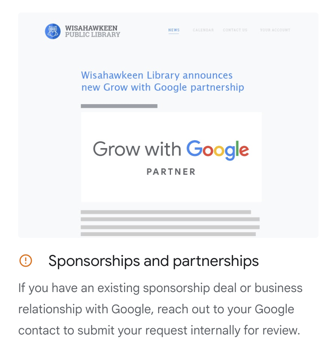


Image 2:



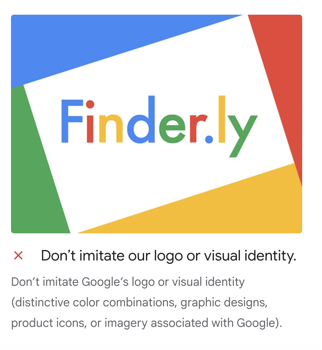


1. What is shown in Image 1 and Image 2?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the text ?


-------Response--------
 1. Image 1 is a screenshot of a web page that promotes a partnership between the Wishawken Public Library and Google. Image 2 is a screenshot of a web page that shows Google's visual identity guidelines.


2. Both images are related to Google.


3. The text in Image 1 is about the partnership between the Wishawken Public Library and Google. The text in Image 2 is about Google's visual identity guidelines.

In [9]:
image_ask_first_3_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Ask_first_3.png"
image_dont_do_this_3_url =  "https://storage.googleapis.com/spls/gsp520/Google_Branding/Dont_do_this_3.png"
image_ask_first_3 = load_image_from_url(image_ask_first_3_url)
image_dont_do_this_3 = load_image_from_url(image_dont_do_this_3_url)

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1 and Image 2?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the text ?
"""

contents = [prompt1, image_ask_first_3, prompt2, image_dont_do_this_3, prompt3]

generation_config = GenerationConfig(
    temperature=0.0,
    top_p=0.8,
    top_k=40,
    candidate_count=1,
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Task 1.3. Generating a video description

**Note:** If you encounter any authentication error, go to the **Navigation menu**, click **Vertex AI > Dashboard**, then click **"Enable all Recommended APIs** and run this cell. **

In [ ]:
prompt = """
What is the product shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

What is the product shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?




-------Response--------


#### Task 1.4. Extracting tags of objects throughout the video

In [ ]:
prompt = """
Answer the following questions using the video only:
- What is in the video?
- Which game are they playing in the video?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Task 1.5. Asking more questions about a video

**Note:** Although this video contains audio, Gemini does not currently support audio input and will only answer based on the video.

In [ ]:
prompt = """
Answer the following questions using the video only:
What is the main product highlighted?
What are the main features of the product highlighted?


Provide the answer JSON.
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Task 1.6. Retrieving extra information beyond the video

In [ ]:
prompt = """
Which features are promoted in the video?
What is the best hashtag for this video based on the description ?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)
print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")


## Task 2. Multimodal retrieval augmented generation (RAG)

### Import libraries

In [ ]:
from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)


### Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model

In [ ]:
text_model = GenerativeModel("gemini-1.0-pro")
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Download custom Python modules and utilities

The cell below will download some helper functions needed for this notebook, to improve readability. You can also view the code (`intro_multimodal_rag_utils.py`) directly on [Github](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

In [ ]:
import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")


# download the helper scripts from utils folder
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")


### Get documents and images from Cloud Storage

In [ ]:
# download documents and images used in this notebook
!gsutil -m rsync -r gs://spls/gsp520 .
print("Download completed")

### Complete the missing parts

For this task, complete the missing parts of each cell to progress to the next section. These will be denoted with INSERT and an instruction to complete.

**Note:** You can skip any notebook cells that are noted Colab only. **


#### Task 2.1. Build metadata of documents containing text and images

##### Task 2.1.1. Import helper functions to build metadata

In [ ]:
from utils.intro_multimodal_rag_utils import get_document_metadata

##### Task 2.1.2. Extract and store metadata of text and images from a document

In [ ]:
# Specify the PDF folder with multiple PDF

# pdf_folder_path = "/content/data/" # if running in Google Colab/Colab Enterprise
pdf_folder_path = "Google_Branding/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""

# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model,  # we are passing gemini 1.0 pro vision model
    pdf_folder_path,
    image_save_dir="images_s",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")

##### Task 2.1.3. Inspect the processed text metadata

In [ ]:
text_metadata_df.head()

##### Task 2.1.4. Import the helper functions to implement RAG

In [ ]:
from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

#### Task 2.2. Create a user query

In [ ]:
# We are just passing a simple text query, not any images.

query = """Questions:
 - What are the key expectations that users can have from Google regarding the provision and development of its services?
- What specific rules and guidelines are established for users when using Google services?
- How does Google handle intellectual property rights related to the content found within its services, including content owned by users, Google, and third parties? 
- What legal rights and remedies are available to users in case of problems or disagreements with Google?
- How do the service-specific additional terms interact with these general Terms of Service, and which terms take precedence in case of any conflicts?
 """

#### Task 2.3. Get all relevant text chunks


In [ ]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)


#### Task 2.4. Create context_text and context_images

In [ ]:
# combine all the selected relevant text chunks
context_text = []
for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"])
final_context_text = "\n".join(context_text)

#### Task 2.6. Pass context to Gemini

In [ ]:
prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}
 - Image Context:
 {context_images}

{query}

Answer:
"""

# Generate Gemini response with streaming output
Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.4, max_output_tokens=2048),
    )
)
